In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set(style="ticks", color_codes=True)

import chardet
import codecs

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import folium
from folium import plugins
from scipy import stats

%matplotlib inline
plt.style.use('seaborn-white')

**Melbourne house prices less data set**

Variable Price is missing 14590 values

In [3]:
less = pd.read_csv('/Users/mille/Desktop/Supervised learning potpourri/MELBOURNE_HOUSE_PRICES_LESS.csv', low_memory=False)
print('Dataframe dimensions:', less.shape)


# providing more information per column on data types and number of null values
tab_info=pd.DataFrame(less.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(less.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(less.isnull().sum()/less.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info




Dataframe dimensions: (63023, 13)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
column type,object,object,int64,object,float64,object,object,object,int64,object,int64,float64,object
null values (nb),0,0,0,0,14590,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,23.1503,0,0,0,0,0,0,0,0


**Melbourne housing full data set**

Contains many more variables with many more missing or null values

In [4]:
full = pd.read_csv('/Users/mille/Desktop/Supervised learning potpourri/Melbourne_housing_FULL.csv', low_memory=False)
print('Dataframe dimensions:', full.shape)


# providing more information per column on data types and number of null values
tab_info=pd.DataFrame(full.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(full.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(full.isnull().sum()/full.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info




Dataframe dimensions: (34857, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
column type,object,object,int64,object,float64,object,object,object,float64,float64,...,float64,float64,float64,float64,float64,object,float64,float64,object,float64
null values (nb),0,0,0,0,7610,0,0,0,1,1,...,8226,8728,11810,21115,19306,3,7976,7976,3,3
null values (%),0,0,0,0,21.8321,0,0,0,0.00286886,0.00286886,...,23.5993,25.0394,33.8813,60.5761,55.3863,0.00860659,22.8821,22.8821,0.00860659,0.00860659


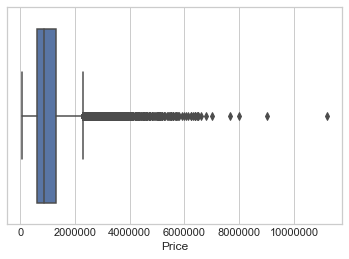

In [11]:
# Distribution showing outliers
# Dataframe full
sns.set_style("whitegrid")
fig, ax = plt.subplots()
sns.boxplot(full.Price)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

#### **The boxplot of the price shows that the data is mean is near 100,000. However, the data is spread all the way to over 1 million. In order to show this data in histogram it needs to be transformed by a log.**

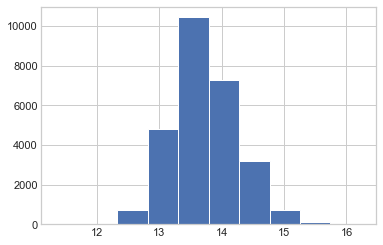

In [13]:
# Distribution of ln(Price)
fig, ax = plt.subplots()
plt.hist(np.log(full.Price.dropna()))
ax.ticklabel_format( style='plain')
plt.show()

In [14]:

# Drop Price NaN
full['Price'].dropna(inplace=True)

# Add new variable
full['lnPrice'] = np.log(full.Price)

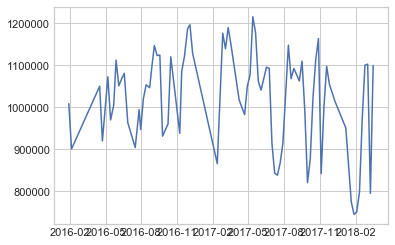

In [15]:
# Convert Date to datetime
full["Date"] = pd.to_datetime(full["Date"],dayfirst=True)

PriceMeans = full.Price.groupby(full.Date).mean()


# Plot changes over time
plt.plot(PriceMeans)
plt.show()

## **Data cleaning**

In [16]:

# Create new suburb variable for suburbs with more than 200 sales
suburblist = full.Suburb.value_counts()
tokeep = list(suburblist.index[full.Suburb.value_counts()>200])
print(tokeep)
# Create new suburb feature and set as categorical
full['Suburb_200'] = full.Suburb.where(full.Suburb.isin(tokeep), 'other').astype('category')

# Drop 10 outliers in Landsize
full = full.loc[full.Landsize<40000, :]

# Use BuildingArea where Landsize == 0 and where np.NaN
full['Landsize_adj'] = full.loc[:, 'Landsize']
full.loc[full['Landsize']<0.1, 'Landsize_adj'] = full.loc[full['Landsize']<0.1, 'BuildingArea'].values

# For remainder of Landsize_adj == 0 and np.Nan use avg Landsize based on suburb
full['Landsize_adj'].fillna(full.groupby('Suburb')['Landsize'].transform('mean'), inplace=True)

['Reservoir', 'Bentleigh East', 'Richmond', 'Glen Iris', 'Preston', 'Kew', 'Brighton', 'Brunswick', 'South Yarra', 'Hawthorn', 'Northcote', 'Camberwell', 'Balwyn North', 'Essendon', 'Coburg', 'Glenroy', 'Brighton East', 'Pascoe Vale', 'St Kilda', 'Port Melbourne', 'Malvern East', 'Prahran', 'Thornbury', 'Balwyn', 'Bentleigh', 'Yarraville', 'Surrey Hills', 'Elwood', 'Moonee Ponds', 'Hawthorn East', 'Hampton', 'Toorak', 'Carnegie', 'Footscray', 'Doncaster', 'Craigieburn', 'Newport', 'Ascot Vale', 'Brunswick West', 'Mount Waverley', 'Armadale', 'Burwood', 'Glen Waverley', 'Ivanhoe', 'Keilor East', 'Maribyrnong', 'Malvern', 'Templestowe Lower', 'Fawkner', 'Williamstown', 'Melbourne', 'West Footscray']


In [17]:
# Create ln(Buildingsize) on Landsize_adj
full['lnLandsize'] = np.log(full.loc[:, 'Landsize_adj'])

# Set Type as categorical
full['Type'] = full.loc[:,'Type'].astype('category')

# Create suburb dummies
dummies = pd.get_dummies(full.loc[:, ['Suburb_200', 'Type']])

# Drop unused columns and merge with dummies
X = pd.concat([full.drop(['Address', 'Method', 'SellerG', 'Date',
                    'Postcode', 'Bedroom2', 'BuildingArea',
                    'YearBuilt', 'CouncilArea', 'Lattitude',
                    'Longtitude', 'Regionname', 'Price',
                    'Suburb', 'Type', 'Landsize_adj'], axis=1), 
               dummies],axis=1)

In [18]:
# Drop NaN
X.dropna(inplace=True)
print('20,611 originally', X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17689 entries, 1 to 34856
Data columns (total 65 columns):
Rooms                           17689 non-null int64
Distance                        17689 non-null float64
Bathroom                        17689 non-null float64
Car                             17689 non-null float64
Landsize                        17689 non-null float64
Propertycount                   17689 non-null float64
lnPrice                         17689 non-null float64
Suburb_200                      17689 non-null category
lnLandsize                      17689 non-null float64
Suburb_200_Armadale             17689 non-null uint8
Suburb_200_Ascot Vale           17689 non-null uint8
Suburb_200_Balwyn               17689 non-null uint8
Suburb_200_Balwyn North         17689 non-null uint8
Suburb_200_Bentleigh            17689 non-null uint8
Suburb_200_Bentleigh East       17689 non-null uint8
Suburb_200_Brighton             17689 non-null uint8
Suburb_200_Brighton East  

In [19]:
X['lnRooms'] = np.log(full.loc[:, 'Rooms'])
# 6 distance observations are 0, set to 0.1 instead (next nearest 0.8)

X['Distance'] = X.Distance.where(X.Distance>0.7, 0.1)
X['lnDistance'] = np.log(X.loc[:, 'Distance'])

# 34 Bathroom observations are 0, set to 0.1
X.loc[X.Bathroom==0, 'Bathroom'] = 0.1
X['lnBathroom'] = np.log(X.loc[:, 'Bathroom'])

# 1107 Car observations are 0, set to 0.1
X['Car'] = X.Car.where(X.Car>1, 0.1)
X['lnCar'] = np.log(X.loc[:, 'Car'])
X['lnPropertycount'] = np.log(full.loc[:, 'Propertycount'])

In [20]:
X.drop(['Rooms', 'Distance', 'Bathroom',
        'Car', 'Propertycount','Landsize',
       'Suburb_200_other', 'Type_u', 'Suburb_200'], axis=1, inplace=True)

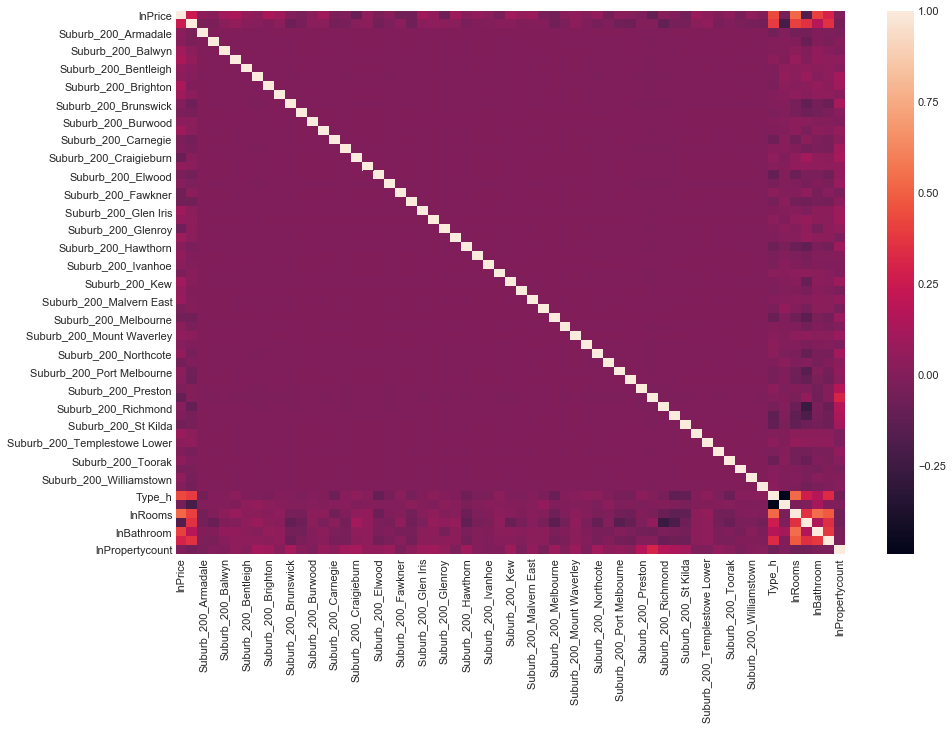

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr())
plt.show()

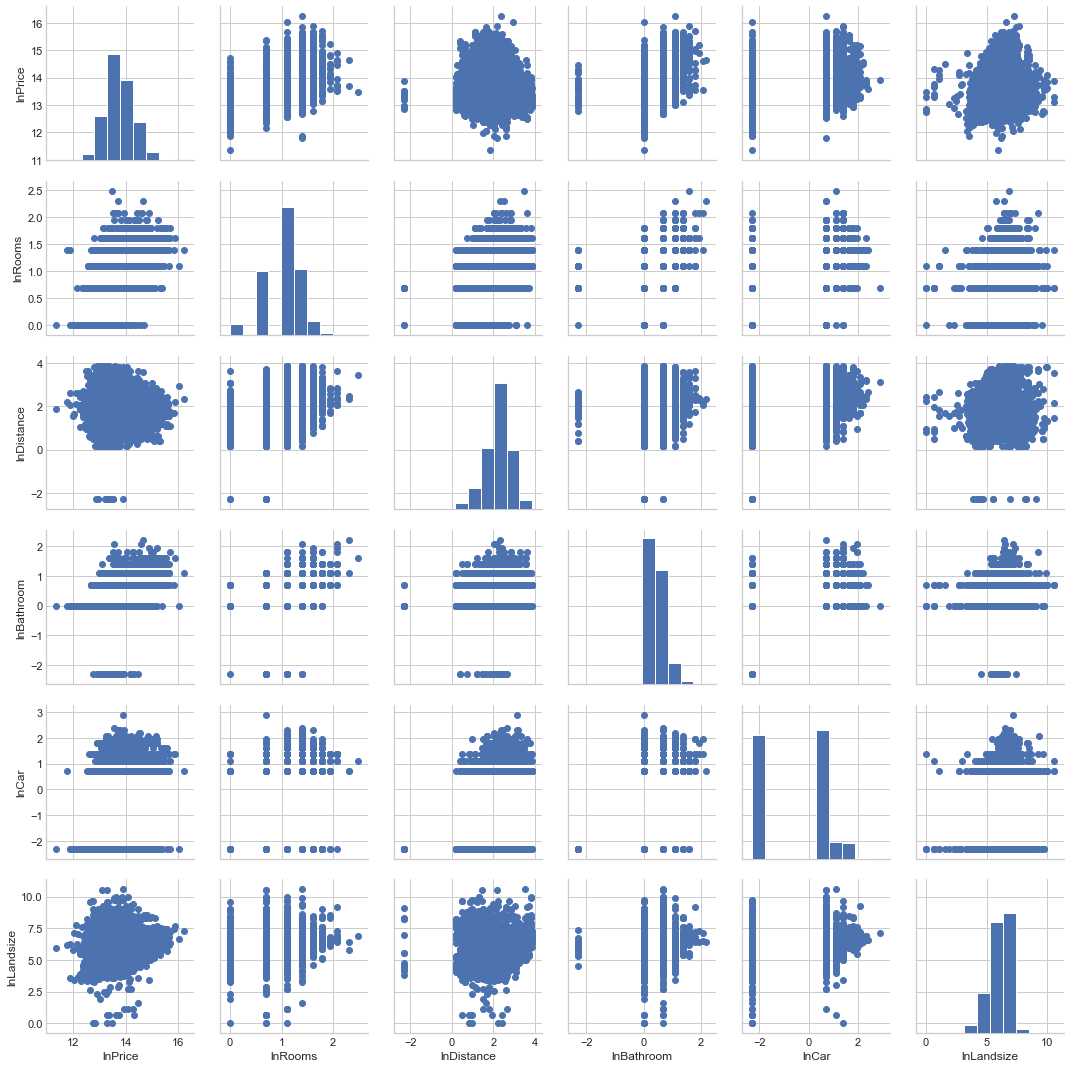

In [22]:
sns.set_style('whitegrid')
g = sns.PairGrid(X.loc[:, ['lnPrice', 'lnRooms', 'lnDistance', 'lnBathroom', 'lnCar', 'lnLandsize']])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()

In [23]:

from sklearn import model_selection

# Split out y
y = X.loc[:, 'lnPrice']
X.drop(['lnPrice'], axis=1, inplace=True)

# Splitting into train and test

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

ols = sm.OLS(y_train, X_train)
result = ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                lnPrice   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     454.8
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:47:13   Log-Likelihood:                -2745.3
No. Observations:               13266   AIC:                             5613.
Df Residuals:                   13205   BIC:                             6070.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

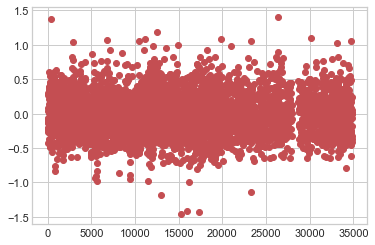

In [25]:
y_hat = result.predict(X_test)
errors = y_test - y_hat

plt.plot(errors, 'ro')
plt.show()

# Conclusion

Positively correlated with price: landsize, type of house, number of rooms, bathrooms, carports
The more ammendities or increased size of the house positively influence the price of the house. Certain suburbs or neighbourhoods either positively or negatively influence the housing price, based on the property value of the surrounding houses and how safe the neighbourhoods are. 

Interesting insights:
1. Higher density housing is correlated with poored neighbourhoods. Space and size of the house is  related to higher price. 
2. Distance to the center of the city is not linearly correlated with housing price. Wealthier suburbs are further from the city where their is more space for the house and it can be larger size as well. 

The OLS model has a R-squared value of 0.674 which is a substainal value. 